In [18]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
numpy
"""
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import mnist

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [19]:
mnist_trainset=datasets.MNIST(root='./mnist',train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_testset=datasets.MNIST(root='./mnist',train=False, download=True, transform=torchvision.transforms.ToTensor())

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)

len(mnist_trainset)

60000

torch.Size([60000, 28, 28])
torch.Size([60000])


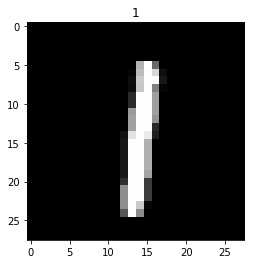

In [20]:
print(mnist_trainset.train_data.size())     # (60000, 28, 28)
print(mnist_trainset.train_labels.size())   # (60000)
plt.imshow(mnist_trainset.train_data[40].numpy(), cmap='gray')
plt.title('%i' % mnist_trainset.train_labels[40])
plt.show()

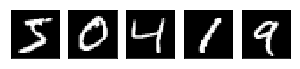

In [21]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# initialize figure
f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 1), squeeze=False)
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = mnist_trainset.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

### Training

tensor(0.2333, grad_fn=<MseLossBackward>) 



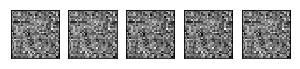

tensor(0.0462, grad_fn=<MseLossBackward>) 



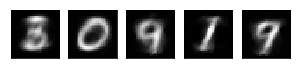

tensor(0.0455, grad_fn=<MseLossBackward>) 



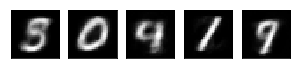

tensor(0.0407, grad_fn=<MseLossBackward>) 



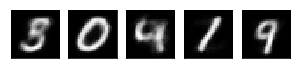

tensor(0.0394, grad_fn=<MseLossBackward>) 



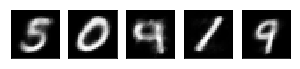

tensor(0.0367, grad_fn=<MseLossBackward>) 



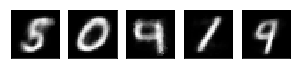

tensor(0.0366, grad_fn=<MseLossBackward>) 



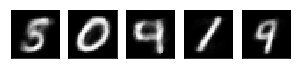

tensor(0.0345, grad_fn=<MseLossBackward>) 



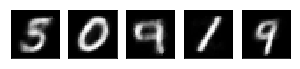

tensor(0.0379, grad_fn=<MseLossBackward>) 



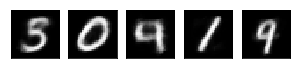

tensor(0.0370, grad_fn=<MseLossBackward>) 



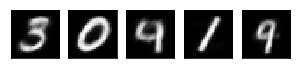

In [22]:
for epoch in range(EPOCH):
    for step, data in enumerate(train_loader):
        x,b_labels=data
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 1000 == 0:
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 1), squeeze=False)
            print(loss,'\n')
            plt.ion()  
            for i in range(N_TEST_IMG):
                a[0][i].clear()
                a[0][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(()); a[0][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

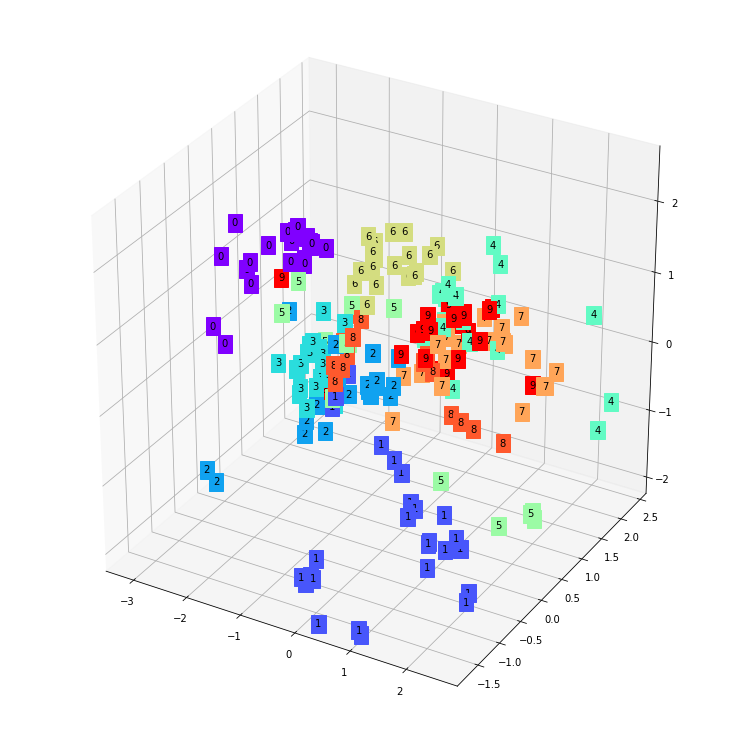

In [23]:
# visualize in 3D plot
view_data = mnist_trainset.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2, figsize=(10, 10)); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = mnist_trainset.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(y, z, x, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()